# Code to generate multi-class masks for COCO dataset

In [1]:
from pycocotools import coco, cocoeval, _mask
from pycocotools import mask as maskUtils 
import array
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import os
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
%matplotlib inline

In [2]:
CATEGORY_NAMES=['bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train','truck', 'boat',
                'bird','cat','dog','horse','sheep','cow', 'elephant', 'bear', 'zebra','giraffe']

ANNOTATION_FILE_VAL = '/root/Internship-Valeo/data/COCO/annotations_trainval2014/annotations/instances_val2014.json'
ANNOTATION_FILE_TRAIN = '/root/Internship-Valeo/data/COCO/annotations_trainval2014/annotations/instances_train2014.json'


coco_train = coco.COCO(ANNOTATION_FILE_TRAIN)
coco_val = coco.COCO(ANNOTATION_FILE_VAL)

imgIds_train = []
if CATEGORY_NAMES!=None:
    # iterate for each individual class in the list
    for className in CATEGORY_NAMES:
        # get all images containing given super class
        catIds_train = coco_train.getCatIds(catNms=className)
        imgIds_train += coco_train.getImgIds(catIds=catIds_train)
        
else:
    imgIds_train = coco_train.getImgIds()

# Now, filter out the repeated images    
unique_imgIds_train = []
for i in range(len(imgIds_train)):
    if imgIds_train[i] not in unique_imgIds_train:
        unique_imgIds_train.append(imgIds_train[i])

images_train = coco_train.loadImgs(unique_imgIds_train)
dataset_size = len(images_train)

print("Number of images containing the filter classes:", dataset_size)

loading annotations into memory...
Done (t=11.30s)
creating index...
index created!
loading annotations into memory...
Done (t=4.67s)
creating index...
index created!
Number of images containing the filter classes: 33866


In [3]:
imgIds_val = []
if CATEGORY_NAMES!=None:
    # iterate for each individual class in the list
    for className in CATEGORY_NAMES:
        # get all images containing given super class
        catIds_val = coco_val.getCatIds(catNms=className)
        imgIds_val += coco_val.getImgIds(catIds=catIds_val)

else:
    imgIds_val = coco_val.getImgIds()
    

    
# Now, filter out the repeated images      
unique_imgIds_val = []
for i in range(len(imgIds_val)):
    if imgIds_val[i] not in unique_imgIds_val:
        unique_imgIds_val.append(imgIds_val[i])

images_val = coco_val.loadImgs(unique_imgIds_val)
dataset_size = len(images_val)

print("Number of images containing the filter classes:", dataset_size)

Number of images containing the filter classes: 16523


In [4]:
from random import shuffle


shuffle(imgIds_train)
shuffle(imgIds_val)

# imgIds_train = imgIds_train[0:6000]
# imgIds_val = imgIds_val[0:600]

In [5]:
train_images = ["COCO_train2014_{0:012d}.jpg".format(ids) for ids in unique_imgIds_train]
val_images = ["COCO_val2014_{0:012d}.jpg".format(ids) for ids in unique_imgIds_val]

In [6]:
print(len(train_images) , len(val_images))

33866 16523


In [7]:
train_dir = '/root/Internship-Valeo/data/COCO/anntrain2014'

In [8]:
if os.listdir(train_dir) is not None:
    for f in os.listdir(train_dir):
        os.remove(train_dir+'/'+f)

In [9]:
val_dir = '/root/Internship-Valeo/data/COCO/annval2014'

In [10]:
if os.listdir(val_dir) is not None:
    for f in os.listdir(val_dir):
        os.remove(val_dir+'/'+f)

In [11]:
import shutil
source_dir = '/root/Internship-Valeo/data/COCO/train2014'
for f in train_images:
    shutil.copy(source_dir+'/'+f, train_dir)

In [12]:
source_dir = '/root/Internship-Valeo/data/COCO/val2014'
for f in val_images:
    shutil.copy(source_dir+'/'+f, val_dir)

In [10]:
print(len(os.listdir(train_dir)))

33866


In [13]:
from PIL import Image

In [15]:
# Load the categories in a variable
catIDs = coco_train.getCatIds()
cats = coco_train.loadCats(catIDs)

In [16]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

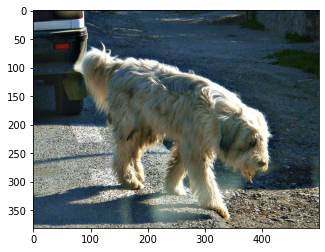

In [17]:
img = images_train[10000]
I = io.imread(train_dir+'/'+img['file_name'])/255.0
plt.imshow(I)

In [18]:
count = 0 

catIds_train = coco_train.getCatIds(catNms=CATEGORY_NAMES) 

for ID in unique_imgIds_train:
    file_path = "/root/Internship-Valeo/data/COCO/m_t_2014/COCO_train2014_{0:012d}.jpg".format(ID)
  
    sampleImgIds = coco_train.getImgIds(imgIds = [ID])
    sampleImgDict = coco_train.loadImgs(sampleImgIds[np.random.randint(0,len(sampleImgIds))])[0]

    annIds = coco_train.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_train, iscrowd=0)
    anns = coco_train.loadAnns(annIds)


    mask = coco_train.annToMask(anns[0])
    for i in range(len(anns)):
        className = getClassName(anns[i]['category_id'], cats)
        pixel_value = CATEGORY_NAMES.index(className)+1
        mask = np.maximum(coco_train.annToMask(anns[i])*pixel_value, mask)
#     mask = Image.fromarray(mask) # saving as PIL image distorts the pixel values
    np.save(file_path, mask)
    count = count + 1
print(count)

33866


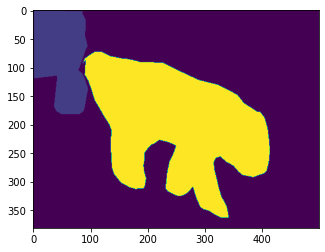

In [19]:
I = np.load( '/root/Internship-Valeo/data/COCO/m_t_2014/'+img['file_name']+'.npy')
plt.imshow(Image.fromarray(I))

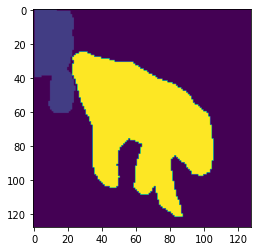

In [20]:
import cv2
# mask = cv2.imread('/root/Internship-Valeo/data/COCO/m_t_2014/'+'COCO_train2014_000000181021.jpg.npy', -1)
mask = Image.fromarray(I)
mask = mask.resize((128 , 128), resample=Image.NEAREST)
mask = np.array(mask)
# mask = mask.reshape((128 , 128))
plt.imshow(mask)

In [21]:
n_classes = 19
one_hot = np.zeros((128, 128, n_classes))
for i, unique_value in enumerate(np.unique(mask)):
    print(i,unique_value)
    one_hot[:, :, unique_value][mask == unique_value] = 1

0 0
1 2
2 11


In [22]:
sum(mask==0)

array([128,  88,  88,  88,  88,  89,  89,  89,  89,  86,  72,  68,  67,
        67,  68,  68,  68,  68,  68,  68,  70,  74,  82,  90, 111, 110,
       106, 101,  98,  96,  94,  91,  91,  88,  87,  62,  59,  58,  56,
        55,  55,  54,  53,  53,  53,  53,  53,  53,  54,  56,  75,  78,
        79,  80,  81,  82,  83,  82,  82,  80,  69,  64,  60,  56,  54,
        55,  55,  56,  58,  59,  62,  63,  60,  57,  54,  53,  53,  53,
        52,  52,  52,  58,  65,  70,  74,  76,  78,  83,  86,  85,  84,
        84,  84,  84,  86,  87,  87,  87,  88,  89,  91,  91,  93,  95,
       102, 115, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128])

In [23]:
sum(one_hot[:,:,0]==1)

array([128,  88,  88,  88,  88,  89,  89,  89,  89,  86,  72,  68,  67,
        67,  68,  68,  68,  68,  68,  68,  70,  74,  82,  90, 111, 110,
       106, 101,  98,  96,  94,  91,  91,  88,  87,  62,  59,  58,  56,
        55,  55,  54,  53,  53,  53,  53,  53,  53,  54,  56,  75,  78,
        79,  80,  81,  82,  83,  82,  82,  80,  69,  64,  60,  56,  54,
        55,  55,  56,  58,  59,  62,  63,  60,  57,  54,  53,  53,  53,
        52,  52,  52,  58,  65,  70,  74,  76,  78,  83,  86,  85,  84,
        84,  84,  84,  86,  87,  87,  87,  88,  89,  91,  91,  93,  95,
       102, 115, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
       128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128])

In [24]:
# !mkdir maskval2014

In [26]:
count = 0 

catIds_val = coco_val.getCatIds(catNms=CATEGORY_NAMES) 

for ID in unique_imgIds_val:
    file_path = "/root/Internship-Valeo/data/COCO/m_v_2014/COCO_val2014_{0:012d}.jpg".format(ID)
  
    sampleImgIds = coco_val.getImgIds(imgIds = [ID])
    sampleImgDict = coco_val.loadImgs(sampleImgIds[np.random.randint(0,len(sampleImgIds))])[0]

    annIds = coco_val.getAnnIds(imgIds=sampleImgDict['id'], catIds=catIds_val, iscrowd=0)
    anns = coco_val.loadAnns(annIds)


    mask = coco_val.annToMask(anns[0])
    for i in range(len(anns)):
        className = getClassName(anns[i]['category_id'], cats)
        pixel_value = CATEGORY_NAMES.index(className)+1
        mask = np.maximum(coco_val.annToMask(anns[i])*pixel_value, mask)
#     mask = Image.fromarray(mask) # saving as PIL image distorts the pixel values
    np.save(file_path, mask)
    count = count + 1
print(count)

16523
